In [1]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/Neuronal_astrocyte_interactions")

In [9]:
library(ggplot2)
library(ggrepel)
library(WGCNA)
library(tidyverse)
library(GEOquery)
library(CorLevelPlot)
library(gridExtra)
library(gprofiler2)
library(ggpubr)
library(reshape2)
library(purrr)
library(RColorBrewer)
library(matrixStats)
library(igraph)
library(ggraph)
library(mixOmics)
library(dplyr)
library(writexl)
library(pheatmap)
library(readxl)

Warning message:
"package 'readxl' was built under R version 4.2.3"


In [3]:
samples_info<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/RNAseq_data/samples_info.csv")
samples_info$Well_ID <- sub(".*_", "", samples_info$sample)
rownames(samples_info)<-samples_info$sample

color_vector_cell_line<- setNames(samples_info$color_2,samples_info$cell_line_v2) 
color_vector_cell_line <- color_vector_cell_line[!duplicated(names(color_vector_cell_line))]

shape_project <- c("S105199" = 21, "S105586" = 22,"S106319"=23)
counts_astro<-read.table("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_astrocytes/ruviii.2000.norm_voom.txt",header = TRUE)
rownames(counts_astro)<-counts_astro$Gene

colnames_counts_astro<-colnames(counts_astro)
colnames_counts_astro<-gsub("\\.", "-", colnames_counts_astro)
colnames_counts_astro<-str_replace_all(colnames_counts_astro, "SMARCB1_KSS_CRISPR", "SMARCB1_KSS-CRISPR")
colnames(counts_astro)<-colnames_counts_astro
counts_astro<-counts_astro[-length(counts_astro)]

counts_neurons<-read.table("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/ruviii.2000.norm_voom.txt",header = TRUE)
rownames(counts_neurons)<-counts_neurons$Gene

#replace "." to "-" for colnames
colnames_counts_neurons<-colnames(counts_neurons)
colnames_counts_neurons<-gsub("\\.", "-", colnames_counts_neurons)
colnames_counts_neurons<-str_replace_all(colnames_counts_neurons, "SMARCB1_KSS_CRISPR", "SMARCB1_KSS-CRISPR")
colnames(counts_neurons)<-colnames_counts_neurons
counts_neurons<-counts_neurons[-length(counts_neurons)]

In [4]:
neuron_mat<-as.matrix(counts_neurons)
astro_mat<-as.matrix(counts_astro)

In [5]:
# --- 1. Select most variable genes ---
top_var_genes <- function(mat, top_n = 500) {
  vars <- rowVars(mat)
  names(vars) <- rownames(mat)
  top_genes <- names(sort(vars, decreasing = TRUE))[1:top_n]
  return(mat[top_genes, , drop = FALSE])
}

# Select top 500 most variable genes in each matrix (adjust number if needed)
neu_mat_var <- top_var_genes(neuron_mat, top_n = 2000)
ast_mat_var <- top_var_genes(astro_mat, top_n = 2000)


In [6]:
# Optional: rank transform to reduce outlier effects
rank_transform <- function(mat){
  t(apply(mat, 1, rank))
}

# Apply to gene × sample matrices
neu_mat_var_rank <- rank_transform(neu_mat_var)
ast_mat_var_rank <- rank_transform(ast_mat_var)

# # Then transpose for spls
X <- t(neu_mat_var_rank)  # samples × genes
Y <- t(ast_mat_var_rank)  # samples × genes

In [ ]:
#HERE!!

In [7]:
set.seed(123)

# -------------------------
# PARAMETERS
# -------------------------
n_boot <- 10000      # number of bootstrap iterations
ncomp <- 1        # number of components
keepX <- rep(100, ncomp)  # top 100 genes per component
keepY <- rep(100, ncomp)

# -------------------------
# BOOTSTRAP STABLE GENE SELECTION
# -------------------------
selected_genes <- list()

for(b in 1:n_boot){
    
  idx <- sample(1:nrow(X), size = floor(0.8*nrow(X)), replace=FALSE)

  Xb <- X[idx, , drop=FALSE]
  Yb <- Y[idx, , drop=FALSE]
  
  # Make rownames unique to satisfy sPLS
  rownames(Xb) <- make.unique(rownames(Xb))
  rownames(Yb) <- make.unique(rownames(Yb))
  
  boot_res <- spls(Xb, Yb, ncomp=ncomp, keepX=keepX, keepY=keepY, mode="regression")
  
  # Save selected genes per component
  selected_genes[[b]] <- list(
    neu1 = names(which(boot_res$loadings$X[,1] != 0)),
    #neu2 = names(which(boot_res$loadings$X[,2] != 0)),
    ast1 = names(which(boot_res$loadings$Y[,1] != 0))
    #ast2 = names(which(boot_res$loadings$Y[,2] != 0))
  )
}
# -------------------------
# IDENTIFY STABLE GENES
# -------------------------
# Count frequency of selection across bootstrap
freq_neu1 <- table(unlist(lapply(selected_genes, function(x) x$neu1)))
#freq_neu2 <- table(unlist(lapply(selected_genes, function(x) x$neu2)))
freq_ast1 <- table(unlist(lapply(selected_genes, function(x) x$ast1)))
#freq_ast2 <- table(unlist(lapply(selected_genes, function(x) x$ast2)))

# Choose stable genes: e.g., selected in >= 50% of bootstraps
stable_neu1 <- names(freq_neu1[freq_neu1 >= 0.3*n_boot])
#stable_neu2 <- names(freq_neu2[freq_neu2 >= 0.5*n_boot])
stable_ast1 <- names(freq_ast1[freq_ast1 >= 0.3*n_boot])
#stable_ast2 <- names(freq_ast2[freq_ast2 >= 0.5*n_boot])



Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not converge"
Warning message:
"The SGCCA algorithm did not co

In [ ]:
write.table(freq_neu1,"freq_Neu_1C_X100_Y100_10000.txt")
write.table(freq_ast1,"freq_Ast_1C_X100_Y100_10000.txt")

In [ ]:
length(stable_neu1)
stable_neu1_1000b<-stable_neu1
#stable_neu2
length(stable_ast1)
stable_ast1_1000b<-stable_ast1
#stable_ast2 

In [ ]:
#do not re run the boot, reload results
# freq_neu1<-read.table("freq_Neu_1C_X100_Y100_10000.txt")
# freq_ast1<-read.table("freq_Ast_1C_X100_Y100_10000.txt")
# # Choose stable genes: e.g., selected in >= 50% of bootstraps
# n_boot <- 10000
# stable_neu1 <- freq_neu1[freq_neu1$freq_neu1 >= 0.3*n_boot ,"Var1"]
# #stable_WGCNA2 <- names(freq_WGCNA2[freq_WGCNA2 >= 0.5*n_boot])
# stable_ast1 <-freq_ast1[freq_ast1$freq_ast1 >= 0.3*n_boot ,"Var1"]

In [14]:
#do not re run the boot, reload results
file_path <- "spls_results_10000.xlsx"
n_boot <- 10000

# 4. Read specific sheets into separate data frames
freq_neu1 <- read_excel(file_path, sheet = "Neuron_Stable_Genes")
freq_ast1 <- read_excel(file_path, sheet = "Astrocyte_Stable_Genes")

stable_neu1<-freq_neu1[freq_neu1$Frequency >= 0.3*n_boot ,"Gene"]
stable_ast1<-freq_ast1[freq_ast1$Frequency >= 0.3*n_boot ,"Gene"]
stable_neu1<-stable_neu1$Gene
stable_ast1<-stable_ast1$Gene

In [22]:
# -------------------------
# FINAL sPLS WITH ONLY STABLE GENES
# -------------------------
X_stable <- X[, stable_neu1, drop=FALSE]
Y_stable <- Y[, stable_ast1, drop=FALSE]

spls_res <- spls(X_stable, Y_stable, ncomp=1, keepX=length(stable_neu1),
                 keepY=length(stable_ast1), mode="regression")

In [23]:
# -------------------------
# EXTRACT VARIATES
# -------------------------
X_comp1 <- spls_res$variates$X[,1]
Y_comp1 <- spls_res$variates$Y[,1]

df <- data.frame(
  sample = rownames(X_stable),
  Neuron1 = X_comp1,
  Astro1  = Y_comp1
) %>%
  left_join(samples_info, by=c("sample"="sample"))

# Now 'df' contains component scores for stable genes


In [26]:
# Fit model
lm_fit <- lm(Astro1 ~ Neuron1, data = df)

# Predicted values and residuals
df$pred <- predict(lm_fit)
df$residual <- df$Astro1 - df$pred
threshold <- 2.5 * sd(df$residual)

# Upper/lower deviation bands
df$upper <- df$pred + threshold
df$lower <- df$pred - threshold

# Mark outliers
df$outlier <- abs(df$residual) > threshold

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


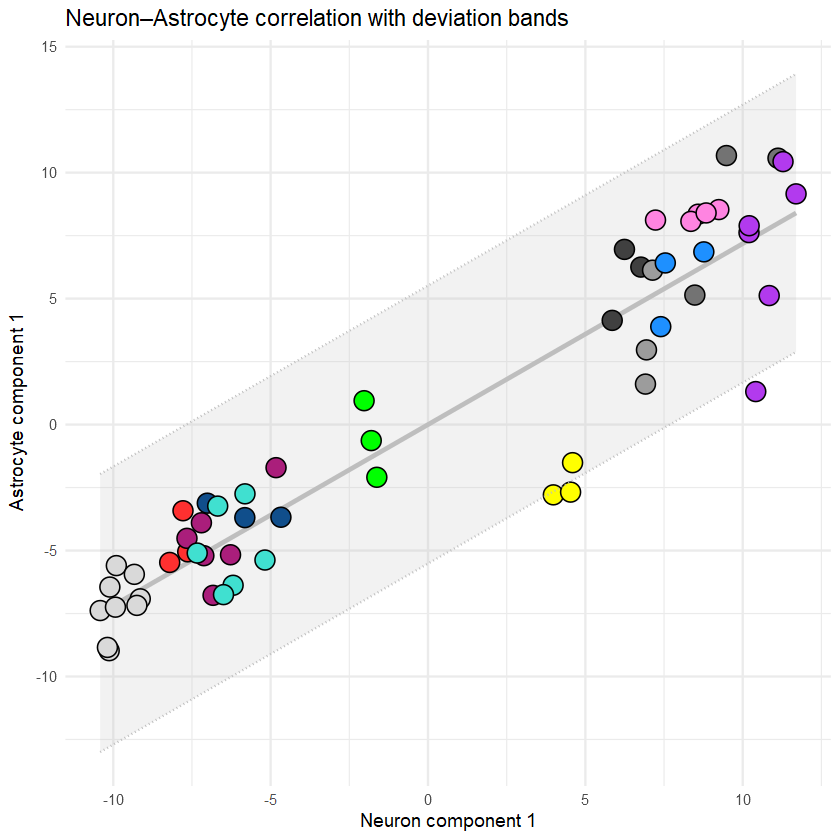

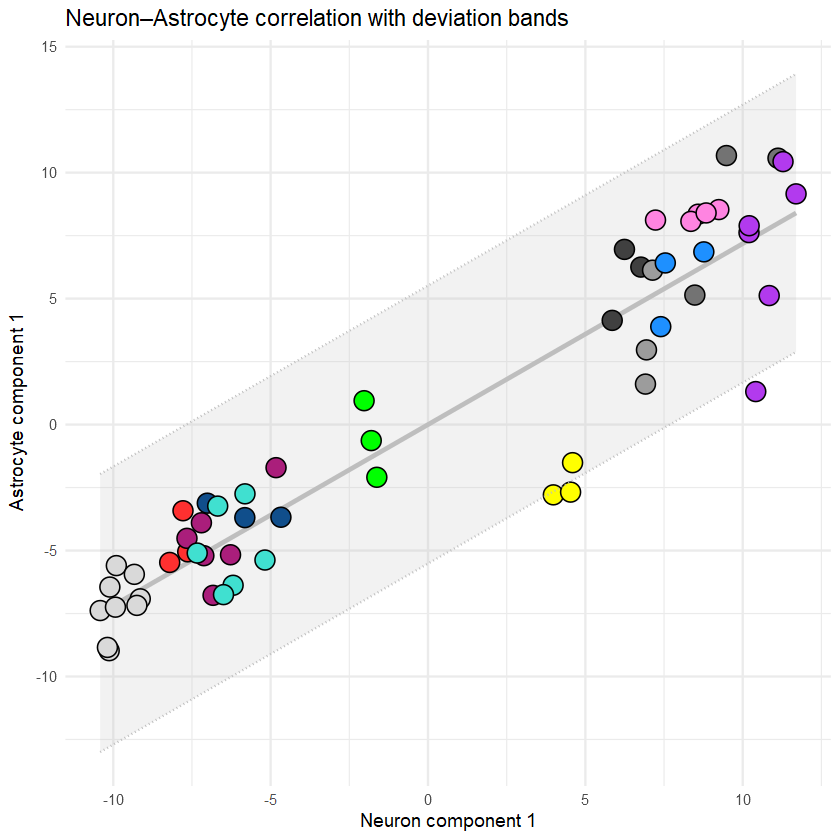

In [27]:

# Plot
p <- ggplot(df, aes(x = Neuron1, y = Astro1)) +
  # shaded area between bands
  geom_ribbon(aes(ymin = lower, ymax = upper), fill = "grey", alpha = 0.2) +

  # regression line
  geom_smooth(method = "lm", se = FALSE, color = "grey") +

  # normal points
  geom_point(aes(fill = color_2), shape = 21, color = "black", size = 5) +

  
  # optional: dotted lines along bands
  geom_line(aes(y = upper), linetype = "dotted", color = "grey") +
  geom_line(aes(y = lower), linetype = "dotted", color = "grey") +

  theme_minimal() +
  labs(x = "Neuron component 1", y = "Astrocyte component 1",
       title = "Neuron–Astrocyte correlation with deviation bands") +
  scale_fill_identity()

p

ggsave(paste0('interactions_2000hv_b10000_100genes_2.5sd.pdf'),
                  width = 5.3,   # inches
                  height = 5,
                   plot=p)# inches
p

In [33]:
# Extract loadings for X (neurons) and Y (astrocytes)
loadings_x <- as.data.frame(spls_res$loadings$X)
loadings_x <- tibble::rownames_to_column(loadings_x, var = "Variable")

loadings_y <- as.data.frame(spls_res$loadings$Y)
loadings_y <- tibble::rownames_to_column(loadings_y, var = "Variable")

# Extract variates (component scores)
variates_x <- as.data.frame(spls_res$variates$X)
variates_y <- as.data.frame(spls_res$variates$Y)

# Combine variates with sample information (from your 'df')
sample_scores <- df  # Your existing data frame with sample info

# Stable gene frequencies (from your bootstrap)
stable_neu1_freq <- as.data.frame(freq_neu1[freq_neu1$Frequency >= 0.3 * n_boot,])
stable_ast1_freq <- as.data.frame(freq_ast1[freq_ast1$Frequency >= 0.3 * n_boot,])
colnames(stable_neu1_freq) <- c("Gene", "Frequency")
colnames(stable_ast1_freq) <- c("Gene", "Frequency")

In [34]:
sheets_list <- list(
  "X_Loadings" = loadings_x,
  "Y_Loadings" = loadings_y,
  "Sample_Scores" = sample_scores,
  "Neuron_Stable_Genes" = stable_neu1_freq,
  "Astrocyte_Stable_Genes" = stable_ast1_freq
)
write_xlsx(sheets_list, path = "spls_results_10000b.xlsx")

In [35]:
# Extract selected genes for component 1 and 2
neu_genes_selected_c1 <- names(which(spls_res$loadings$X[,1] != 0))
#neu_genes_selected_c2 <- names(which(spls_res$loadings$X[,2] != 0))
#neu_genes_selected_c3 <- names(which(spls_res$loadings$X[,2] != 0))

ast_genes_selected_c1 <- names(which(spls_res$loadings$Y[,1] != 0))
#ast_genes_selected_c2 <- names(which(spls_res$loadings$Y[,2] != 0))
#ast_genes_selected_c3 <- names(which(spls_res$loadings$Y[,3] != 0))

build_cor_network <- function(neu_genes, ast_genes, X, Y, comp_id){
  X_sub <- X[, neu_genes, drop=FALSE]
  Y_sub <- Y[, ast_genes, drop=FALSE]

  expand.grid(neuron_gene = neu_genes,
              astro_gene  = ast_genes) %>%
    rowwise() %>%
    mutate(r = cor(X_sub[, neuron_gene], Y_sub[, astro_gene])) %>%
    ungroup() %>%
    mutate(component = comp_id)
}

cor_network_c1 <- build_cor_network(neu_genes_selected_c1, ast_genes_selected_c1, X, Y, "Comp1")
#cor_network_c2 <- build_cor_network(neu_genes_selected_c2, ast_genes_selected_c2, X, Y, "Comp2")
#cor_network_c3 <- build_cor_network(neu_genes_selected_c3, ast_genes_selected_c3, X, Y, "Comp3")

cor_network_all <- bind_rows(cor_network_c1)#


In [ ]:
p<-ggplot(cor_network_all, aes(x=r, fill=component)) +
  geom_histogram(bins=50, alpha=0.6, position="identity") +
  facet_wrap(~component, scales="free_y") +
  theme_minimal()
ggsave(paste0('correlations_2000hv_b10000_100genes.pdf'),
                  width = 5.3,   # inches
                  height = 5,
                   plot=p)# inches
p

In [36]:
cor_network<-cor_network_c1

In [37]:
rat_to_human_gprofiler<- function(x){
genes<-gorth(query = x, source_organism = "rnorvegicus", 
      target_organism = "hsapiens", mthreshold = Inf, filter_na = FALSE)

return(genes)
}
humanized<-rat_to_human_gprofiler(unique(cor_network$astro_gene))
humanized <- humanized %>%
  # Replace "N/A" with original input
  mutate(ortholog_name = ifelse(ortholog_name == "N/A", input, ortholog_name)) %>%
  # Clean strings (remove extra spaces)
  mutate(ortholog_name = str_trim(ortholog_name))

humanized_combined <- humanized %>%
  group_by(input) %>%   # or group by "input" if you prefer
  summarise(
    ortholog_name = paste(unique(ortholog_name), collapse = "/"),
    across(everything(), first)   # keep the first value of other columns
  ) %>%
  ungroup()

In [38]:
cor_network$astro_gene_h<-factor(humanized_combined$ortholog_name[match(cor_network$astro_gene,humanized_combined$input)])

In [39]:
# --- 4. Filter strong correlations ---
cor_network_filtered <- cor_network %>% filter(abs(r) > 0.6)  # adjust threshold
cor_network_filtered$neuron_gene<-factor(paste0("n_",cor_network_filtered$neuron_gene))
cor_network_filtered$astro_gene_h<-factor(paste0("a_",cor_network_filtered$astro_gene_h))
# --- 6. Optional: visualize as a network ---
edges <- cor_network_filtered[,c("neuron_gene","astro_gene_h","r")] 
nodes <- tibble(
  name = unique(c(edges$neuron_gene, edges$astro_gene_h)),
  type = ifelse(name %in% edges$neuron_gene, "neuron", "astro")
)

graph <- graph_from_data_frame(edges, vertices = nodes, directed = FALSE)



Warning message:
"Using one column matrices in `filter()` was deprecated in dplyr 1.1.0.
ℹ Please use one dimensional logical vectors instead."


In [40]:
#considering only sig corr?
#and highlight in bold then the ones in the SNAP?
build_cor_network <- function(neu_genes, ast_genes, X, Y, comp_id) {
  X_sub <- X[, neu_genes, drop = FALSE]
  Y_sub <- Y[, ast_genes, drop = FALSE]

  expand.grid(neuron_gene = neu_genes,
              astro_gene  = ast_genes) %>%
    rowwise() %>%
    mutate(
      r = cor(X_sub[, neuron_gene], Y_sub[, astro_gene]),
      p_value = cor.test(X_sub[, neuron_gene], Y_sub[, astro_gene])$p.value
    ) %>%
    ungroup() %>%
    mutate(component = comp_id)
}

# Example usage
cor_network_c1 <- build_cor_network(neu_genes_selected_c1, ast_genes_selected_c1, X, Y, "Comp1")
# Combine multiple components if needed
# cor_network_all <- bind_rows(cor_network_c1, cor_network_c2, cor_network_c3)



In [41]:
rat_to_human_gprofiler<- function(x){
genes<-gorth(query = x, source_organism = "rnorvegicus", 
      target_organism = "hsapiens", mthreshold = Inf, filter_na = FALSE)

return(genes)
}
humanized<-rat_to_human_gprofiler(unique(cor_network_c1$astro_gene))
humanized <- humanized %>%
  # Replace "N/A" with original input
  mutate(ortholog_name = ifelse(ortholog_name == "N/A", input, ortholog_name)) %>%
  # Clean strings (remove extra spaces)
  mutate(ortholog_name = str_trim(ortholog_name))

humanized_combined <- humanized %>%
  group_by(input) %>%   # or group by "input" if you prefer
  summarise(
    ortholog_name = paste(unique(ortholog_name), collapse = "/"),
    across(everything(), first)   # keep the first value of other columns
  ) %>%
  ungroup()
cor_network_c1$astro_gene_h<-factor(humanized_combined$ortholog_name[match(cor_network_c1$astro_gene,humanized_combined$input)])

In [ ]:
write.csv(cor_network_c1,"cor_network_2000hv_b10000_100genes.csv")

In [42]:
# Filter for significant correlations (e.g., p < 0.05)
sig_cor_network <- cor_network_c1 %>% filter(p_value < 0.05)

In [ ]:
p<-ggplot(sig_cor_network, aes(x=r, fill=component)) +
  geom_histogram(bins=100, alpha=0.6, position="identity") +
  facet_wrap(~component, scales="free_y") +
  theme_minimal()
ggsave(paste0('correlations_sig_2000hv_b10000_100genes.pdf'),
                  width = 5.3,   # inches
                  height = 5,
                   plot=p)# inches
p

In [43]:
# --- 4. Filter strong correlations ---
cor_network_filtered <- sig_cor_network %>% filter(abs(r) >= 0.5)  # adjust threshold
#cor_network_filtered$neuron_gene<-factor(paste0("n_",cor_network_filtered$neuron_gene))
#cor_network_filtered$astro_gene_h<-factor(paste0("a_",cor_network_filtered$astro_gene_h))
# --- 6. Optional: visualize as a network ---
edges <- cor_network_filtered[,c("neuron_gene","astro_gene_h","r")] 
nodes <- tibble(
  name = unique(c(edges$neuron_gene, edges$astro_gene_h)),
  type = ifelse(name %in% edges$neuron_gene, "neuron", "astro")
)
graph <- graph_from_data_frame(edges, vertices = nodes, directed = FALSE)
# Compute degree (number of connections)
nodes <- nodes %>%
  left_join(
    tibble(name = names(degree(graph)), degree = degree(graph)),
    by = "name"
  )
#make some testing to see how stable are the selected genes when running the algorithm

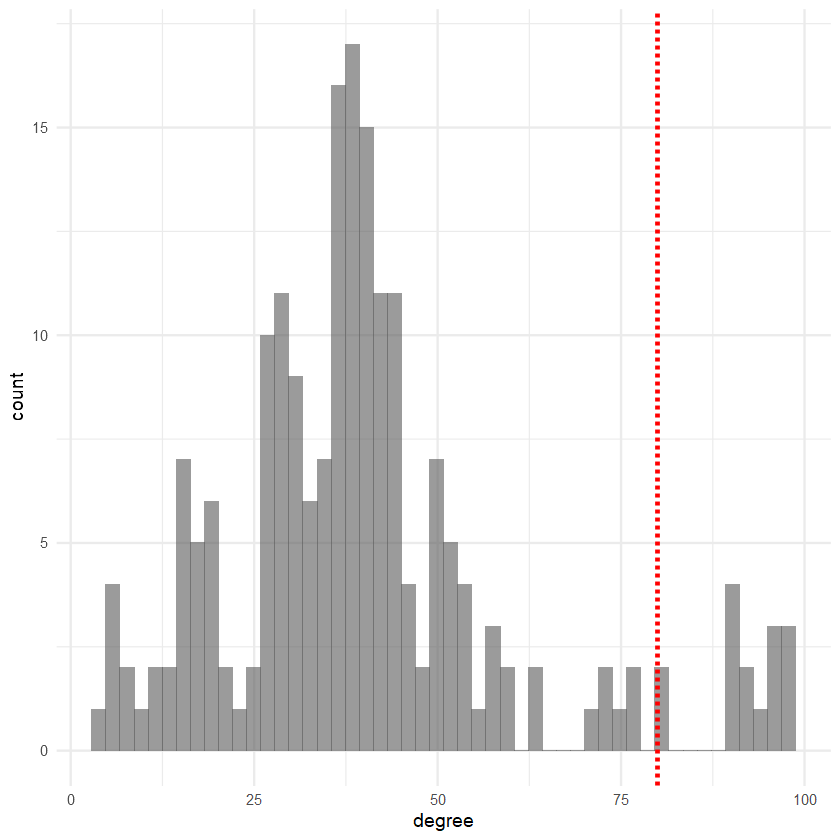

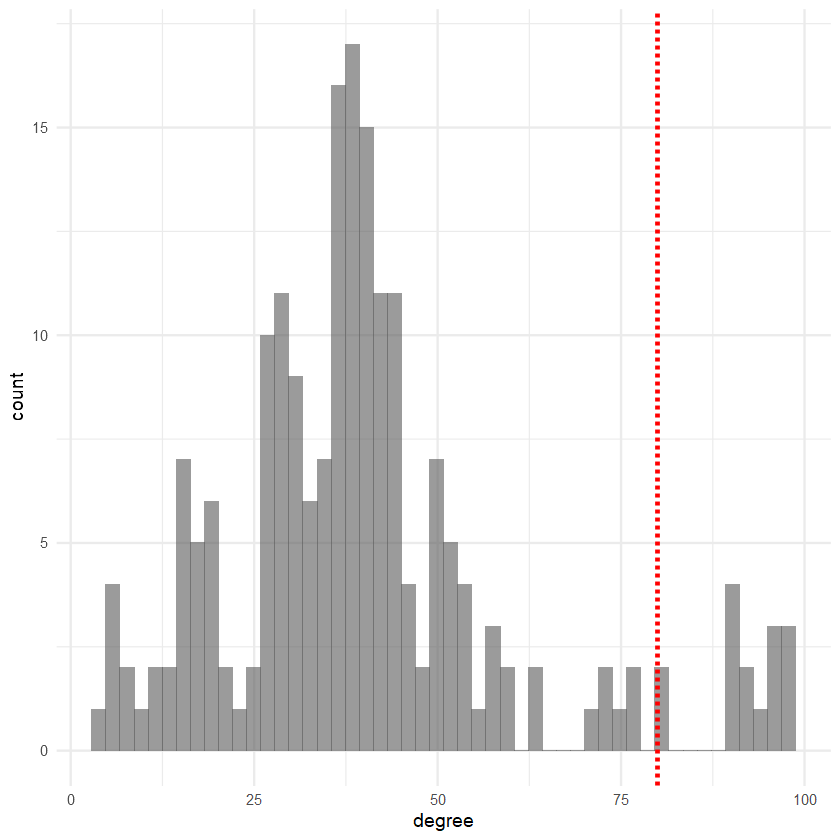

In [55]:
p<-ggplot(nodes, aes(x = degree)) +
  geom_histogram(bins = 50, alpha = 0.6, position = "identity") +
  geom_vline(xintercept = 80, color = "red", linetype = "dashed", size = 1) +
  theme_minimal()
p
ggsave(paste0('nodes_connectivity.pdf'),
                  width = 5.3,   # inches
                  height = 5,
                   plot=p)# inches


In [ ]:
p<-ggplot(sig_cor_network, aes(x=r, fill=component)) +
  geom_histogram(bins=100, alpha=0.6, position="identity") +
  facet_wrap(~component, scales="free_y") +
  theme_minimal()
ggsave(paste0('correlations_sig_2000hv_b10000_100genes.pdf'),
                  width = 5.3,   # inches
                  height = 5,
                   plot=p)# inches
p

In [ ]:
#show highly connected genes, color by type the text (black and grey) in bold
#show intersection with ?SNAP-a, SNAPn,? 


In [45]:
SNAP_a<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/RNAseq_data/curated_gene_lists/SNAP-a.csv")
SNAP_a<-SNAP_a %>% arrange(desc(SNAP.a))  %>%  # sort descending
  slice_head(n = 4000)
SNAP_n<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/RNAseq_data/curated_gene_lists/SNAP-n.csv")
SNAP_n<-SNAP_n %>% arrange(desc(SNAP.n))  %>%  # sort descending
  slice_head(n = 4000)        # select top 10 rows

In [46]:
astro_genes_clean <- unique(unlist(strsplit(as.character(cor_network_filtered$astro_gene_h), "/")))
#length(astro_genes_clean)

In [47]:
neu_show<-intersect(SNAP_n$Gene,unique(cor_network_filtered$neuron_gene))
ast_show<-intersect(SNAP_a$Gene,astro_genes_clean)


In [48]:
# --- 5. Highlight flag with "/" handling for astro + hub combination ---
nodes <- nodes %>%
  rowwise() %>%
  mutate(
    highlight_flag = {
      # Check astro match (with "/")
      astro_match <- type == "astro" && any(strsplit(name, "/")[[1]] %in% ast_show)
      # Check neuron match
      neuron_match <- type == "neuron" && name %in% neu_show
      # Check hub
      hub_match <- degree > 80

      if (astro_match && hub_match) {
        "SNAP-a+hub"
      } else if (neuron_match && hub_match) {
        "SNAP-n+hub"
      } else if (astro_match) {
        "SNAP-a"
      } else if (neuron_match) {
        "SNAP-n"
      } else if (hub_match) {
        "hub"
      } else {
        "none"
      }
    }
  ) %>%
  ungroup()

In [49]:
levels(factor(unique(nodes$highlight_flag)))

[1] "hub"        "none"       "SNAP-a"     "SNAP-a+hub" "SNAP-n"

In [50]:
# --- rebuild graph with updated nodes (with highlight_flag) ---
graph <- graph_from_data_frame(edges, vertices = nodes, directed = FALSE)


In [52]:
# Get node attributes as a data frame
nodes_df <- data.frame(
  name = V(graph)$name,
  type = V(graph)$type,
  highlight_flag = V(graph)$highlight_flag,
  degree = degree(graph)  # number of connections
)

head(nodes_df)

,name,type,highlight_flag,degree
,<chr>,<chr>,<chr>,<dbl>
ANKRD20A7P,ANKRD20A7P,neuron,none,47
ASB2,ASB2,neuron,none,44
BCL11B,BCL11B,neuron,none,60
CA2,CA2,neuron,none,50
CEACAMP3,CEACAMP3,neuron,none,40
CLRN1-AS1,CLRN1-AS1,neuron,none,40


In [57]:
count_by_flag <- nodes_df %>%
  group_by(highlight_flag) %>%
  summarise(n_genes = n())

count_by_flag

highlight_flag,n_genes
<chr>,<int>
SNAP-a,10
SNAP-a+hub,3
SNAP-n,15
hub,11
none,160


In [59]:
nodes_df %>%
  group_by(highlight_flag) %>%
  summarise(
    n_genes = n(),
    proportion = n() / nrow(nodes_df) *100
  )

highlight_flag,n_genes,proportion
<chr>,<int>,<dbl>
SNAP-a,10,5.025126
SNAP-a+hub,3,1.507538
SNAP-n,15,7.537688
hub,11,5.527638
none,160,80.402010


In [60]:
dim(nodes_df)

[1] 199   4

In [53]:
write.csv(nodes_df,"cor_network_2000hv_b10000_100genes_nodes.csv")

In [ ]:
g <- ggraph(graph, layout = "dh") +
  # edges first
  geom_edge_link(aes(color = r), alpha = 0.8) +
  
  # nodes: fill = type, border color = highlight_flag, stroke by flag
  geom_node_point(
    aes(fill = type,
        color = highlight_flag,
        size = degree,
        stroke = ifelse(highlight_flag == "none", 0.3, 1.2)),
    shape = 21
  ) +
  
  # labels only for highlighted nodes
  geom_node_text(
    aes(label = ifelse(highlight_flag != "none", name, "")),
    repel = TRUE, size = 3, fontface = "italic",
  max.overlaps = Inf   # allow all labels to attempt placement
) +
  
  # edge color scale
  scale_edge_color_gradient2(low = "blue", mid = "grey80", high = "red", midpoint = 0) +
  
  # fill = node type (gray tones)
  scale_fill_manual(values = c(neuron = "grey40", astro = "grey70")) +
  
  # border color = highlight flag
  scale_color_manual(values = c(
    "none"       = "black",
    "SNAP-a"     = "skyblue",
    "SNAP-n"     = "orange",
    "hub"        = "purple",
    "SNAP-a+hub" = "darkblue",
    "SNAP-n+hub" = "darkred"
  )) +
  
  scale_size_continuous(range = c(2, 6)) +
  theme_void()
g
ggsave(paste0('NW_2000hv_10000b_100genes_05sig_hub80dh.pdf'),
                  width = 6,   # inches
                  height = 6,
                   plot=g)# inches


In [ ]:
gene_outlier_diff <- apply(X[, neuron_genes], 2, function(g) {
  t.test(g[outliers], g[-outliers])
})


In [ ]:
X_stable <- X[, stable_neu1, drop=FALSE]
Y_stable <- Y[, stable_ast1, drop=FALSE]

In [ ]:
outliers_CHD8 <- df[df$outlier & df$cell_line_v2 == "CHD8_1", ]
rownames(outliers_CHD8)<-outliers_CHD8$sample

In [ ]:
Y_pred <- predict(spls_res, X_stable)$predict


In [ ]:
# Predict
pred_array <- predict(spls_res, X_stable)$predict

# If it's a 3D array, take the first component
if (length(dim(pred_array)) == 3) {
  pred_matrix <- pred_array[, , 1]  # first component
} else {
  pred_matrix <- pred_array
}

# Convert to data frame without altering names
Y_pred_df <- as.data.frame(pred_matrix)


In [ ]:
# residual_matrix <- Y_stable - predict(spls_model, newdata = X_stable)
# residual_outliers_CHD8 <- residual_matrix[rownames(outliers_CHD8), ]
# Predict Y from X using sPLS
Y_pred <- predict(spls_res, X_stable)$predict
residual_outliers <- Y_stable[rownames(outliers_CHD8), ] - Y_pred_df[rownames(outliers_CHD8), ]


In [ ]:
# Extract X and Y weights
loadings_X <- spls_res$loadings$X  # weights for neuron genes
loadings_Y <- spls_res$loadings$Y  # weights for astro genes

# Get sPLS component score t (for each sample)
t_comp <- as.matrix(X_stable) %*% loadings_X  # n_samples × 1

# Predicted Y (per gene) = t * loading of Y
Y_pred_mat <- t_comp %*% t(loadings_Y)  # n_samples × n_Y_genes
rownames(Y_pred_mat) <- rownames(X_stable)
colnames(Y_pred_mat) <- colnames(Y_stable)


In [ ]:
outliers_CHD8 <- df$cell_line_v2 == "CHD8_1"#df$outlier & df$cell_line_v2 == "CHD8_1"
residual_outliers <- Y_stable[outliers_CHD8, ] - Y_pred_mat[outliers_CHD8, ]


In [ ]:
residual_outliers

In [ ]:
# Compute mean residual per gene across samples
gene_means <- colMeans(residual_outliers, na.rm = TRUE)

# Keep genes with negative mean residual
negative_genes <- gene_means[gene_means < 0]

# Get gene names
neg_gene_names <- names(negative_genes)
neg_gene_names


In [ ]:
humanized_outliers<-rat_to_human_gprofiler(rat_genes)
humanized_outliers <- humanized_outliers %>%
  # Replace "N/A" with original input
  mutate(ortholog_name = ifelse(ortholog_name == "N/A", input, ortholog_name)) %>%
  # Clean strings (remove extra spaces)
  mutate(ortholog_name = str_trim(ortholog_name))

humanized_outliers_combined <- humanized_outliers %>%
  group_by(input) %>%   # or group by "input" if you prefer
  summarise(
    ortholog_name = paste(unique(ortholog_name), collapse = "/"),
    across(everything(), first)   # keep the first value of other columns
  ) %>%
  ungroup()

In [ ]:
humanized_outliers_combined$ortholog_name

In [ ]:
colnames(res_neg_num)<-humanized_outliers_combined$ortholog_name

In [ ]:

# Subset matrix to negative genes only
res_neg <- residual_outliers[, neg_gene_names]
# convert to numeric if needed
res_neg_num <- as.matrix(res_neg)
rat_genes<-colnames(res_neg_num)
humanized_outliers<-rat_to_human_gprofiler(rat_genes)
humanized_outliers <- humanized_outliers %>%
  # Replace "N/A" with original input
  mutate(ortholog_name = ifelse(ortholog_name == "N/A", input, ortholog_name)) %>%
  # Clean strings (remove extra spaces)
  mutate(ortholog_name = str_trim(ortholog_name))

humanized_outliers_combined <- humanized_outliers %>%
  group_by(input) %>%   # or group by "input" if you prefer
  summarise(
    ortholog_name = paste(unique(ortholog_name), collapse = "/"),
    across(everything(), first)   # keep the first value of other columns
  ) %>%
  ungroup()


colnames(res_neg_num)<-humanized_outliers_combined$ortholog_name
mode(res_neg_num) <- "numeric"



In [ ]:
# Transpose matrix so samples are columns, genes are rows
res_neg_num_t <- t(res_neg_num)

# define diverging colors centered at zero
max_abs <- max(abs(res_neg_num_t), na.rm = TRUE)
breaks <- seq(-max_abs, max_abs, length.out = 101)
colors <- colorRampPalette(c("blue", "white", "red"))(100)

p<-pheatmap(res_neg_num_t,
         color = colors,
         breaks = breaks,
         clustering_distance_rows = "correlation",  # now genes are rows
         clustering_distance_cols = "correlation",  # now samples are columns
         scale = "none",
         #main = "Negative residuals per gene across samples",
         angle_col = 45)  # rotate x-axis labels for readability
ggsave(paste0('heatmap_negative_astrocyte_residuals_CHD8_b10000.pdf'),
                  width = 5,   # inches
                  height = 5,
                   plot=p)# inches


In [ ]:
write.csv(nodes,"nodes_1000b.csv")